# Analysis
### This code analyzes tables with the following removed:
* **Multi** terrain type
* Any row that has null entries which was a consequence of scraping thousands of webpages with sometimes different table structures; this killed about 27% of the scraped data
* Chip time and gun time have been combined to form a minimum time in mins
* Deleted **ALL** races without the corresponding GPX file therefore this is the cross-referenced output
* All GPX information has been added to tables, e.g. elevation and sigma

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils
import warnings
warnings.filterwarnings('ignore')

In [2]:
datadir = '/home/freddy/insight/data/'
filename = datadir + 'data_overlaps_with_gpx_cleaned.csv'
df = pd.read_csv(filename)
print('rows, cols = {0}, {1}'.format(df.shape[0], df.shape[1]))
df=df.drop(columns=['Unnamed: 0'], axis=1)

rows, cols = 31192, 11


In [3]:
df.head()

,age_group,position,race_title,sex,meeting_id,race_dist,min_time,sum_up,sigma,diff
0,U23,1.0,5M,M,257748,5.0,25.250000,51.8,9.01,-0.6
1,U23,2.0,5M,M,257748,5.0,25.450000,51.8,9.01,-0.6
2,SEN,3.0,5M,M,257748,5.0,25.550000,51.8,9.01,-0.6
3,SEN,4.0,5M,M,257748,5.0,25.733333,51.8,9.01,-0.6
4,V40,5.0,5M,M,257748,5.0,25.900000,51.8,9.01,-0.6


In [4]:
# Important maps
conversion_map = {'1M':1.0, '3K':1.86, '2M':2.0, '5K':3.1, '4M':4.0,
                 '5M':5.0, '6M':6.0, '10K':6.2, 'QM':6.55, '7M':7.0,
                 '10M':10.0, 'HM':13.1, 'Mar':26.2}
race_order= ['1M', '3K', '2M', '5K', '4M','5M', '6M', '10K',
             'QM', '7M', '10M', 'HM', 'Mar']
age_order = ['U15','U17','U20','U23','SEN','V35','V40','V45',
             'V50','V55','V60','V65','V70','V75','V80','V85']
age_map = {'U15':0,'U17':0,'U20':0,'U23':0,'SEN':1,'V35':2,'V40':3,
           'V45':3,'V50':4,'V55':4,'V60':5,'V65':5,
           'V70':6,'V75':6,'V80':7,'V85':7}
dist_map = {'1M':1, '3K':2, '2M':3, '5K':4, '4M':5,
            '5M':6, '6M':7, '10K':8, 'QM':9, '7M':10,
            '10M':11, 'HM':12, 'Mar':13}

In [5]:
df=df[df.age_group != 'V115']

In [6]:
df_old = df

In [7]:
df_old.groupby(['race_title'],as_index=False).size()

race_title
10K    15650
10M     2113
1M       199
2M        59
3K       421
4M       216
5K      2623
5M      4791
6M       272
7M       411
HM      3802
Mar      200
QM       434
dtype: int64

In [8]:
df_old.groupby(['age_group'],as_index=False).size()

age_group
SEN    9746
U11      12
U13      48
U15      75
U17     130
U20     344
U23     193
V35    3202
V40    5540
V45    3878
V50    3917
V55    1950
V60    1265
V65     528
V70     270
V75      72
V80      17
V85       4
dtype: int64

In [9]:
race_type = '5K'
df=df[df.race_title==race_type]
subdf=df[df.race_title==race_type].groupby(['meeting_id','sex','age_group','race_title'],as_index=False)['min_time'].median()

In [10]:
Y,Y_dt = [],[]
for index,row in df.iterrows():
    sex  = row.sex
    age  = row.age_group
    time = row.min_time 
    ID   = row.meeting_id
    # Need a smarter method for this...I tried building a dictionary like I would
    # normally do in C++ but it doesn't work that way in python to my knowledge
    temp_row = subdf.loc[(subdf['age_group']==age) & 
                         (subdf['sex']==sex) &
                         (subdf['meeting_id'] == ID)]
    avg_time = (temp_row.min_time).item()
    #print(avg_time.item(), sex, age, time, ID)
    Y.append(0 if (time<=avg_time) else 1)
    Y_dt.append(time-avg_time)

In [11]:
df.position = df.position.astype(int)

In [12]:
X = df
X = X.drop(['position','meeting_id', 'race_title', 'race_dist'], axis=1)

In [13]:
norm = conversion_map[race_type]
X['sum_up'] = X['sum_up']/norm
X['sigma']  = X['sigma']/norm
print('Normalization = %1.4f miles' % norm )

Normalization = 3.1000 miles


In [14]:
age_map = {'U11':0,'U13':0,'U15':0,'U17':0,'U20':0,'U23':0,
           'SEN':1,'V35':2,'V40':2,
           'V45':3,'V50':3,'V55':4,'V60':4,'V65':5,
           'V70':5,'V75':5,'V80':5,'V85':5}
for xrow in [X]:
    xrow['sex'] = xrow['sex'].map( {'W': 1, 'M': 2} ).astype(int)
    xrow['age_group'] = xrow['age_group'].map( age_map )

In [15]:
clf = LogisticRegression()
clf.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
beta = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(clf.coef_))], axis = 1)
print(beta)

           0         0
0  age_group -0.344259
1        sex  1.529040
2   min_time  0.295339
3     sum_up  0.000896
4      sigma -1.362094
5       diff  0.239289


In [28]:
d = []
for index, row in X.iterrows():
    rowidx=0
    sum = 0.0
    for i in row:
        sum += i*beta.values[rowidx][1]
        rowidx+=1
    if sum>50:
        continue
    d.append(sum)

Mu,sigma = 8.813, 1.803


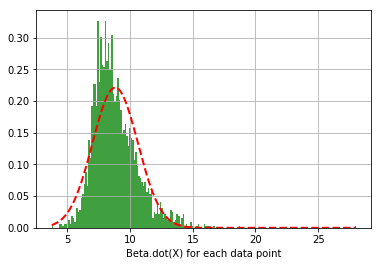

In [30]:
from scipy.stats import norm
n, bins, patches = plt.hist(d, 200, density=True, 
                            facecolor='g', alpha=0.75)
#plt.axis([10, 35, 0.0, 0.175])
plt.grid(True)
plt.xlabel('Beta.dot(X) for each data point')
(mu,sig) = norm.fit(d)
y = mlab.normpdf(bins, mu, sig)
l = plt.plot(bins, y, 'r--', linewidth=2)
print('Mu,sigma = %1.3f, %1.3f' % (mu,sig))
plt.show()

In [31]:
def integrate(lo, hi, n, bins):
    integral = 0.0
    for idx in range(lo,hi):
        integral += n[idx] * (bins[idx+1]-bins[idx])
    return integral

In [32]:
xvals, yvals, dx = [],[],[]
for idx in range(0,len(n)):
    integral = integrate(0, idx, n, bins)
    binpos =  0.5*(bins[idx+1] + bins[idx])
    dx.append(bins[idx+1] - bins[idx])
    xvals.append(binpos)
    yvals.append(integral)

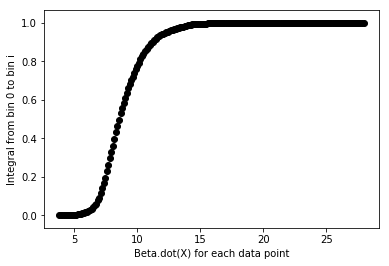

In [33]:
plt.scatter(xvals,yvals,color='black')
plt.xlabel('Beta.dot(X) for each data point')
plt.ylabel('Integral from bin 0 to bin i')
plt.show()

In [34]:
# save the betas
beta.to_csv('inputs/beta_{0}.csv'.format(race_type),sep=',', 
            index=False, header=False)

In [35]:
# Write out the integral plot
f = open('inputs/d_dist_{0}'.format(race_type), 'w')
for idx in range(0,len(xvals)):
    f.write('%d,%1.5f,%1.5f,%1.5f\n' % (idx,xvals[idx],yvals[idx], dx[idx]))
f.close()